In [1]:
import glob
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
import re
import os
import pandas as pd
import pywt
from scipy.fftpack import fft
from warnings import warn
from sklearn import metrics

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Function for FFT

def apply_fft(x, fs, num_samples):
    f = np.linspace(0.0, (fs/2.0), num_samples//2)
    freq_values = fft(x)
    freq_values = 2.0/num_samples * np.abs(freq_values[0:num_samples//2])
    return f, freq_values

In [39]:
# @@@ Function to create dataset from raw vibration signals @@@
# The function processes .mat vibration data files and do segmentation of vibration signals according to 
# desired length of the input segment "num_samples". The function returns segmented vibration signlas "segmented_data", along with their classes " Class_"  

def make_dataset(data_src, num_samples, class_):
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = sorted(data.keys())
    key = keysList[0]
    drive_end_data = data[key]['Y'][0][0][0][6][2]
    drive_end_data = drive_end_data.reshape(-1)
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    segmented_data = silces
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = sorted(data.keys())
        key = keysList[0]
        drive_end_data = data[key]['Y'][0][0][0][6][2]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    
    segmented_data = np.unique(segmented_data, axis= 0) # remove duplicates
    np.random.shuffle( segmented_data) # suffule the data
    Class_ = np.ones(len(segmented_data))*class_
   
    
    return segmented_data, Class_

==========================================================================================================================
# Dataset Creation:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate datasets
 
Link to download the PU dataset: https://mb.uni-paderborn.de/en/kat/main-research/datacenter/bearing-datacenter/data-sets-and-download <br>
After downloading the dataset, vibration signals to be grouped according to their operational conditions/properties in 4 folders (corresponding to number of operational classes in the dataset: 1 normal class and 3 faulty classes) with below folder names:

1.	Healthy
2.	IR&OR
3.	IR
4.	OR

*IR&OR =  Inner Race faults and Outter Race faults <br>
*IR = Inner Race fault <br>
*OR = Outer Race faults <br>



In [2]:
num_samples = 12800 # Set required length of input vibration segment "number of data points"
###########################################
fs = 64000; # Sampling freq.

In [40]:
data_path = (r"C:\dataset") # path were the folders contain vibration signals are located.

cls_1 = 'Healthy/*'; cls_2 = 'IR&OR/*'; cls_3 = 'IR/*'; cls_4 = 'OR/*'

norm, y_norm   = make_dataset(os.path.join(data_path, cls_1), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 3)


In [41]:
X = np.concatenate( (norm, defc1, defc2, defc3) , axis=0, out=None)
Y = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3), axis=0, out=None)

==========================================================================================================================
# Feature Extraction:
=========================================================================================================================== 

In [20]:
#####INPUTS / Parameters #############
wavelet_function = "db4"
num_levels = 5 # k parameter
m = 5 # m parameter

In [21]:
# Wavelet Packet Transform and feature extraction:

num_features = 2**num_levels
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)

for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        # Find  m  highest amplitudes of the spectrum and their corresponding frequencies:
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx] 
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq 
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1

===========================================================================================================================
# Classification:
===========================================================================================================================

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [23]:
labels = pd.Categorical(Y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, 
                                                    shuffle = True, stratify = labels, random_state = 42)

In [27]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [35]:
clf_RF = RandomForestClassifier(criterion='entropy', max_features = 1, min_samples_leaf=1, min_samples_split=2, 
                                max_depth=20, n_estimators=200)
clf_RF.fit(train_data_scaled, y_train)

No. of Samples = 12800 /  k = 5 /  m = 5
ROC AUC = 1.000
F1 Score = 0.996875
Accuracy = 99.688 %


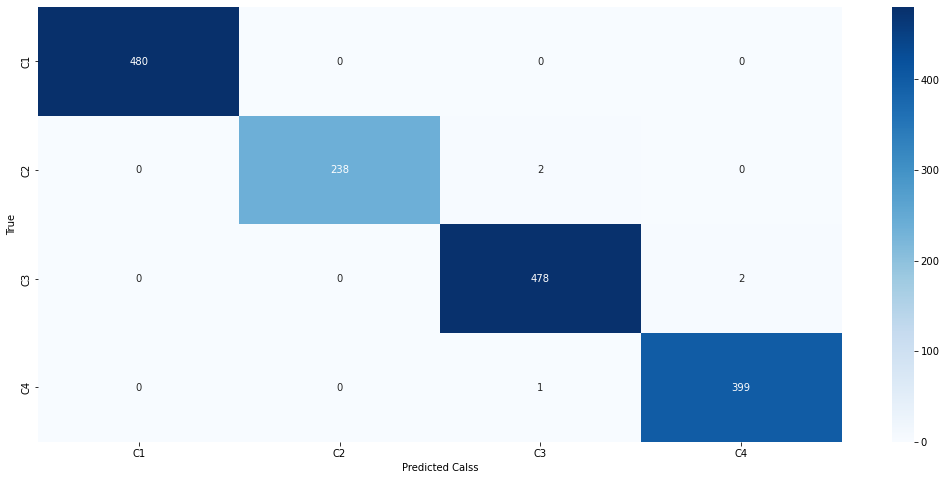

In [36]:
test_predictions = clf_RF.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['C1','C2','C3','C4']
plt.figure(1,figsize=(18,8))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Calss')
plt.ylabel('True Class')
plt.ylabel('True')
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = clf_RF.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print("No. of Samples =", num_samples, "/  k =", num_levels, "/  m =", m, )
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")